### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
from hyperopt import fmin, tpe, hp, STATUS_OK

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [2]:
pd.options.display.width = 50

pd.options.display.max_colwidth = 50

pd.options.display.width = 1200
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

In [3]:
# df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/freMPL-R.csv', low_memory=False)
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [4]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Предобработайте данные

In [5]:
'<Ваш код здесь>'

'<Ваш код здесь>'

In [6]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Female', 1: 'Male'}
{0: 'Other', 1: 'Alone'}


In [7]:
df.drop(["RecordBeg", "RecordEnd"], inplace=True, axis=1)

In [8]:
df.head()

,Exposure,LicAge,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2,0,0,CSP1,Professional,55,0,72,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,0,1,1,CSP55,Private+trip to office,34,0,80,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,1,0,0,CSP1,Professional,33,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,1,0,0,CSP1,Professional,34,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,3,1,0,CSP47,Professional,53,0,72,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


In [9]:
chislennie_colnames = ["Exposure", "LicAge", "Gender", "MariStat", "DrivAge", "HasKmLimit", "BonusMalus", "ClaimAmount", "RiskVar", "ClaimInd"]

In [10]:
categorical_colnames = ["VehAge", "SocioCateg", "VehUsage", "VehBody", "VehPrice", "VehEngine", "VehEnergy", "VehMaxSpeed", "VehClass", "Garage"]

In [11]:
df = pd.get_dummies(data=df, columns=categorical_colnames)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,VehAge_0,VehAge_1,VehAge_10+,VehAge_2,VehAge_3,VehAge_4,VehAge_5,VehAge_6-7,VehAge_8-9,SocioCateg_CSP1,SocioCateg_CSP16,SocioCateg_CSP18,SocioCateg_CSP19,SocioCateg_CSP2,SocioCateg_CSP20,SocioCateg_CSP21,SocioCateg_CSP22,SocioCateg_CSP23,SocioCateg_CSP25,SocioCateg_CSP26,SocioCateg_CSP27,SocioCateg_CSP28,SocioCateg_CSP3,SocioCateg_CSP30,SocioCateg_CSP31,SocioCateg_CSP32,SocioCateg_CSP33,SocioCateg_CSP35,SocioCateg_CSP36,SocioCateg_CSP37,SocioCateg_CSP38,SocioCateg_CSP39,SocioCateg_CSP40,SocioCateg_CSP41,SocioCateg_CSP42,SocioCateg_CSP43,SocioCateg_CSP46,SocioCateg_CSP47,SocioCateg_CSP48,SocioCateg_CSP49,...,VehPrice_G,VehPrice_H,VehPrice_I,VehPrice_J,VehPrice_K,VehPrice_L,VehPrice_M,VehPrice_N,VehPrice_O,VehPrice_P,VehPrice_Q,VehPrice_R,VehPrice_S,VehPrice_T,VehPrice_U,VehPrice_V,VehPrice_W,VehPrice_X,VehPrice_Y,VehPrice_Z,VehPrice_Z1,VehEngine_GPL,VehEngine_carburation,VehEngine_direct injection overpowered,VehEngine_electric,VehEngine_injection,VehEngine_injection overpowered,VehEnergy_GPL,VehEnergy_diesel,VehEnergy_eletric,VehEnergy_regular,VehMaxSpeed_1-130 km/h,VehMaxSpeed_130-140 km/h,VehMaxSpeed_140-150 km/h,VehMaxSpeed_150-160 km/h,VehMaxSpeed_160-170 km/h,VehMaxSpeed_170-180 km/h,VehMaxSpeed_180-190 km/h,VehMaxSpeed_190-200 km/h,VehMaxSpeed_200-220 km/h,VehMaxSpeed_220+ km/h,VehClass_0,VehClass_A,VehClass_B,VehClass_H,VehClass_M1,VehClass_M2,Garage_Collective garage,Garage_None,Garage_Private garage
0,0.583,366,0,0,55,0,72,0.000000,15.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0.200,187,1,1,34,0,80,0.000000,20.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0.083,169,0,0,33,0,63,0.000000,17.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0.375,170,0,0,34,0,63,0.000000,17.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
4,0.500,224,1,0,53,0,72,1418.610272,19.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [12]:
all_colnames = df.columns.tolist()
all_colnames

['Exposure',
 'LicAge',
 'Gender',
 'MariStat',
 'DrivAge',
 'HasKmLimit',
 'BonusMalus',
 'ClaimAmount',
 'RiskVar',
 'ClaimInd',
 'VehAge_0',
 'VehAge_1',
 'VehAge_10+',
 'VehAge_2',
 'VehAge_3',
 'VehAge_4',
 'VehAge_5',
 'VehAge_6-7',
 'VehAge_8-9',
 'SocioCateg_CSP1',
 'SocioCateg_CSP16',
 'SocioCateg_CSP18',
 'SocioCateg_CSP19',
 'SocioCateg_CSP2',
 'SocioCateg_CSP20',
 'SocioCateg_CSP21',
 'SocioCateg_CSP22',
 'SocioCateg_CSP23',
 'SocioCateg_CSP25',
 'SocioCateg_CSP26',
 'SocioCateg_CSP27',
 'SocioCateg_CSP28',
 'SocioCateg_CSP3',
 'SocioCateg_CSP30',
 'SocioCateg_CSP31',
 'SocioCateg_CSP32',
 'SocioCateg_CSP33',
 'SocioCateg_CSP35',
 'SocioCateg_CSP36',
 'SocioCateg_CSP37',
 'SocioCateg_CSP38',
 'SocioCateg_CSP39',
 'SocioCateg_CSP40',
 'SocioCateg_CSP41',
 'SocioCateg_CSP42',
 'SocioCateg_CSP43',
 'SocioCateg_CSP46',
 'SocioCateg_CSP47',
 'SocioCateg_CSP48',
 'SocioCateg_CSP49',
 'SocioCateg_CSP5',
 'SocioCateg_CSP50',
 'SocioCateg_CSP51',
 'SocioCateg_CSP55',
 'SocioCateg_CS

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Columns: 140 entries, Exposure to Garage_Private garage
dtypes: float64(3), int64(7), uint8(130)
memory usage: 8.2 MB


XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [14]:
'<Ваш код здесь>'

df.RiskVar -= 1

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [15]:
FreqCount = pd.DataFrame(df.groupby('RiskVar')["RiskVar"].count().to_frame().rename(columns={"RiskVar": "Count"}) , columns=['Count'])
FreqCount['Freq'] = FreqCount.Count / FreqCount.Count.sum()
FreqCount

,Count,Freq
RiskVar,,
0.0,531,0.013036
1.0,451,0.011072
2.0,660,0.016203
3.0,603,0.014804
4.0,979,0.024035
5.0,902,0.022145
6.0,1634,0.040116
7.0,1439,0.035328
8.0,1170,0.028724


In [16]:
FreqCount.Freq.sum()

1.0

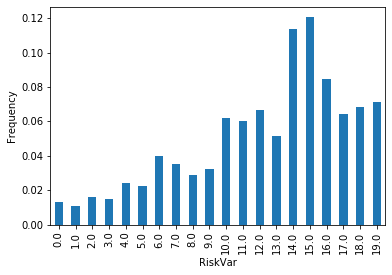

In [17]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [18]:
FreqCount

,Count,Freq
RiskVar,,
0.0,531,0.013036
1.0,451,0.011072
2.0,660,0.016203
3.0,603,0.014804
4.0,979,0.024035
5.0,902,0.022145
6.0,1634,0.040116
7.0,1439,0.035328
8.0,1170,0.028724


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [19]:
# df['weight'] = '<Ваш код здесь>'
df['weight'] = 1
df.loc[df["RiskVar"].isin([14,15]), "weight"] = 0.5
df.weight.value_counts()

1.0    31201
0.5     9531
Name: weight, dtype: int64

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [20]:
train_colnames = df.columns.drop("RiskVar").tolist()
train_colnames

['Exposure',
 'LicAge',
 'Gender',
 'MariStat',
 'DrivAge',
 'HasKmLimit',
 'BonusMalus',
 'ClaimAmount',
 'ClaimInd',
 'VehAge_0',
 'VehAge_1',
 'VehAge_10+',
 'VehAge_2',
 'VehAge_3',
 'VehAge_4',
 'VehAge_5',
 'VehAge_6-7',
 'VehAge_8-9',
 'SocioCateg_CSP1',
 'SocioCateg_CSP16',
 'SocioCateg_CSP18',
 'SocioCateg_CSP19',
 'SocioCateg_CSP2',
 'SocioCateg_CSP20',
 'SocioCateg_CSP21',
 'SocioCateg_CSP22',
 'SocioCateg_CSP23',
 'SocioCateg_CSP25',
 'SocioCateg_CSP26',
 'SocioCateg_CSP27',
 'SocioCateg_CSP28',
 'SocioCateg_CSP3',
 'SocioCateg_CSP30',
 'SocioCateg_CSP31',
 'SocioCateg_CSP32',
 'SocioCateg_CSP33',
 'SocioCateg_CSP35',
 'SocioCateg_CSP36',
 'SocioCateg_CSP37',
 'SocioCateg_CSP38',
 'SocioCateg_CSP39',
 'SocioCateg_CSP40',
 'SocioCateg_CSP41',
 'SocioCateg_CSP42',
 'SocioCateg_CSP43',
 'SocioCateg_CSP46',
 'SocioCateg_CSP47',
 'SocioCateg_CSP48',
 'SocioCateg_CSP49',
 'SocioCateg_CSP5',
 'SocioCateg_CSP50',
 'SocioCateg_CSP51',
 'SocioCateg_CSP55',
 'SocioCateg_CSP56',
 'Soci

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df[train_colnames], df.RiskVar, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [22]:
# xgb_train = '<Ваш код здесь>'
# xgb_valid = '<Ваш код здесь>'
# xgb_test = '<Ваш код здесь>'

xgb_train = xgb.DMatrix(x_train.drop(['weight'], axis=1), (y_train), weight=x_train.weight)
xgb_valid = xgb.DMatrix(x_valid.drop(['weight'], axis=1), (y_valid))
xgb_test = xgb.DMatrix(x_test.drop(['weight'], axis=1), (y_test))


C:\Users\pomaz\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\pomaz\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

Далее обучим нашу модель с оптимальными параметрами

In [23]:
param ={'alpha': 0.8020992938175673,
 'colsample_bytree': 0.7154473206384617,
 'eta': 0.6329518647706083,
 'lambda': 0.5559850361749056,
 'max_depth': 8,
 'min_child_weight': 0.8638760709963555,
 'num_boost_round': 67.0,
 'num_class': 20,
 'subsample': 0.9836932076937734,
'objective': 'multi:softprob'}

In [24]:
'<Ваш код здесь>'

'<Ваш код здесь>'

In [25]:
param

{'alpha': 0.8020992938175673,
 'colsample_bytree': 0.7154473206384617,
 'eta': 0.6329518647706083,
 'lambda': 0.5559850361749056,
 'max_depth': 8,
 'min_child_weight': 0.8638760709963555,
 'num_boost_round': 67.0,
 'num_class': 20,
 'subsample': 0.9836932076937734,
 'objective': 'multi:softprob'}

In [26]:
model = xgb.XGBClassifier(n_estimators=800, **param)

In [27]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(alpha=0.8020992938175673, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7154473206384617, eta=0.6329518647706083,
              gamma=0, lambda=0.5559850361749056, learning_rate=0.1,
              max_delta_step=0, max_depth=8,
              min_child_weight=0.8638760709963555, missing=None,
              n_estimators=800, n_jobs=1, nthread=None, num_boost_round=67.0,
              num_class=20, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9836932076937734, verbosity=1)>

In [28]:
model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(x_valid, y_valid)], verbose=True)

[0]	validation_0-mlogloss:2.90583
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:2.79789
[2]	validation_0-mlogloss:2.72026
[3]	validation_0-mlogloss:2.67428
[4]	validation_0-mlogloss:2.61685
[5]	validation_0-mlogloss:2.5827
[6]	validation_0-mlogloss:2.54718
[7]	validation_0-mlogloss:2.523
[8]	validation_0-mlogloss:2.49572
[9]	validation_0-mlogloss:2.47221
[10]	validation_0-mlogloss:2.44685
[11]	validation_0-mlogloss:2.41947
[12]	validation_0-mlogloss:2.39938
[13]	validation_0-mlogloss:2.37487
[14]	validation_0-mlogloss:2.3537
[15]	validation_0-mlogloss:2.33698
[16]	validation_0-mlogloss:2.3225
[17]	validation_0-mlogloss:2.30371
[18]	validation_0-mlogloss:2.29136
[19]	validation_0-mlogloss:2.28228
[20]	validation_0-mlogloss:2.26654
[21]	validation_0-mlogloss:2.25573
[22]	validation_0-mlogloss:2.24251
[23]	validation_0-mlogloss:2.23206
[24]	validation_0-mlogloss:2.22347
[25]	validation_0-mlogloss:2.21326
[26]	validation_0-mlogloss:2.20653
[

[230]	validation_0-mlogloss:1.87955
[231]	validation_0-mlogloss:1.87899
[232]	validation_0-mlogloss:1.87867
[233]	validation_0-mlogloss:1.87831
[234]	validation_0-mlogloss:1.87759
[235]	validation_0-mlogloss:1.87691
[236]	validation_0-mlogloss:1.87658
[237]	validation_0-mlogloss:1.87611
[238]	validation_0-mlogloss:1.87514
[239]	validation_0-mlogloss:1.87506
[240]	validation_0-mlogloss:1.87376
[241]	validation_0-mlogloss:1.87309
[242]	validation_0-mlogloss:1.87274
[243]	validation_0-mlogloss:1.87235
[244]	validation_0-mlogloss:1.87159
[245]	validation_0-mlogloss:1.87099
[246]	validation_0-mlogloss:1.87045
[247]	validation_0-mlogloss:1.86982
[248]	validation_0-mlogloss:1.86922
[249]	validation_0-mlogloss:1.86878
[250]	validation_0-mlogloss:1.86832
[251]	validation_0-mlogloss:1.868
[252]	validation_0-mlogloss:1.86736
[253]	validation_0-mlogloss:1.86668
[254]	validation_0-mlogloss:1.86607
[255]	validation_0-mlogloss:1.86501
[256]	validation_0-mlogloss:1.86473
[257]	validation_0-mlogloss:1.

[459]	validation_0-mlogloss:1.796
[460]	validation_0-mlogloss:1.79604
[461]	validation_0-mlogloss:1.79568
[462]	validation_0-mlogloss:1.79522
[463]	validation_0-mlogloss:1.79506
[464]	validation_0-mlogloss:1.79479
[465]	validation_0-mlogloss:1.7944
[466]	validation_0-mlogloss:1.79406
[467]	validation_0-mlogloss:1.79379
[468]	validation_0-mlogloss:1.7935
[469]	validation_0-mlogloss:1.79331
[470]	validation_0-mlogloss:1.79325
[471]	validation_0-mlogloss:1.793
[472]	validation_0-mlogloss:1.79277
[473]	validation_0-mlogloss:1.79258
[474]	validation_0-mlogloss:1.7924
[475]	validation_0-mlogloss:1.79228
[476]	validation_0-mlogloss:1.79208
[477]	validation_0-mlogloss:1.79219
[478]	validation_0-mlogloss:1.79204
[479]	validation_0-mlogloss:1.79169
[480]	validation_0-mlogloss:1.79116
[481]	validation_0-mlogloss:1.7908
[482]	validation_0-mlogloss:1.79029
[483]	validation_0-mlogloss:1.79009
[484]	validation_0-mlogloss:1.78999
[485]	validation_0-mlogloss:1.78986
[486]	validation_0-mlogloss:1.78953


XGBClassifier(alpha=0.8020992938175673, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7154473206384617, eta=0.6329518647706083,
              gamma=0, lambda=0.5559850361749056, learning_rate=0.1,
              max_delta_step=0, max_depth=8,
              min_child_weight=0.8638760709963555, missing=None,
              n_estimators=800, n_jobs=1, nthread=None, num_boost_round=67.0,
              num_class=20, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9836932076937734, verbosity=1)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [29]:
dfsets = [{'set': 'train', 'dmat': x_train, 'target': y_train},
          {'set': 'valid', 'dmat': x_valid, 'target': y_valid},
          {'set': 'test', 'dmat': x_test, 'target': y_test}]
for dfset in dfsets:
#     class_preds = '<Ваш код здесь>' # Посчитаем предсказанные значения
    class_preds = model.predict(dfset["dmat"])
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset["target"], class_preds, average="micro")) # Посчитаем F1 Score
    print('Precision Score on ' + str(dfset['set'])+':', precision_score(dfset["target"], class_preds, average='macro')) # Посчитаем Precision Score
    print('Accuracy on ' + str(dfset['set'])+':', accuracy_score(dfset["target"], class_preds)) # Посчитаем Accuracy
    print()

F1 Score on train: 0.9967031425364759
Precision Score on train: 0.9975232151271403
Accuracy on train: 0.9967031425364759

F1 Score on valid: 0.47086743044189855
Precision Score on valid: 0.5494054505861181
Accuracy on valid: 0.47086743044189855

F1 Score on test: 0.46923076923076923
Precision Score on test: 0.5330257448293418
Accuracy on test: 0.46923076923076923



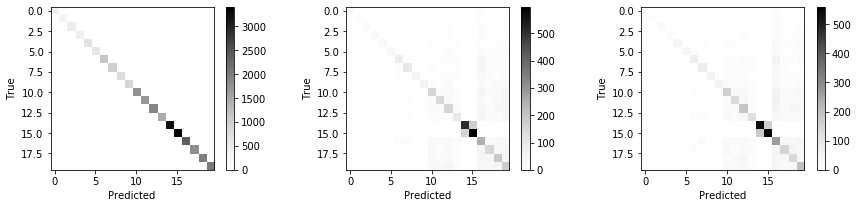

In [30]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], model.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

### Модель достаточно неплохо предсказывает, если учесть что количество классов для предсказания 20 штук. Но видна большая разница в качестве предсказания на тренировочных и валидационных/тестовых данных. Налицо переобучение. С ним нужно бороться. Может покажете как?